Autoregressive model that utilizes the decoder transformer architecture using the Keras/Tensor framework. In laymens terms we want to train a model similar to chat gpt, however instead of training on natural language we will use a patients life long healthcare journey through diagnosis codes.

# Data

In [219]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks
from fn_data_prep import create_sequences
from keras import ops
import keras

We use synthetic claims data to create a sequence ordered by date to mimic a typical text based corpus.

In [220]:
claims = pd.read_csv('../data/DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv')

claims_renamed = claims[['DESYNPUF_ID','CLM_ADMSN_DT','ICD9_DGNS_CD_1']]\
    .rename(columns={'DESYNPUF_ID': 'patient', 'CLM_ADMSN_DT': 'date', 'ICD9_DGNS_CD_1':'dx'})\
    .sort_values(['patient', 'date'])

print(claims_renamed.head(3))

dx_sequences = create_sequences(claims_renamed)

dx_sequences = [seq for seq in dx_sequences if len(seq.split()) >  4]

dx_sequences


            patient      date    dx
0  00013D2EFD8E45D1  20100312  7802
1  00016F745862898F  20090412  1970
2  00016F745862898F  20090831  6186
Created 15140 patient sequences


['6826 485 4589 7211 49122',
 '40291 43491 42731 99662 99662',
 '4271 4372 43491 481 41401',
 '49122 49121 78906 4280 7802 27651 5990 5070',
 '25072 5070 25061 99674 99662',
 '49121 42731 1977 486 40390',
 '5609 6820 3310 99664 7802 1983',
 '9962 49121 49322 1363 V5789 41071',
 '5990 179 2809 V5789 27651',
 '51881 2841 29620 29634 00845 5722 29281 29570 29650 29212 29689',
 '920 8208 51881 4280 03849 42731 49121',
 '7230 53150 4414 4414 44030 6826',
 '71595 2112 2859 56722 56213',
 '486 41071 41071 2111 4240',
 '29532 0389 0088 5070 29680 5990 42789 43491',
 '42731 72633 7336 1623 29530',
 '9972 43411 49122 4280 56081 42731 78791',
 '6824 2761 42731 486 28264',
 '2859 41401 41401 5789 5849',
 '5849 39891 99662 40391 5609',
 '7295 486 41071 41071 27651 41401 7837 41519',
 '486 45341 8404 5110 56212 41071 486',
 '95208 2800 5070 71535 6826',
 '2113 2762 71535 71536 5722',
 '49121 0389 9972 3334 51881 41401 49122',
 '1629 42731 99664 29534 25061 29570 5589',
 '7802 41071 51883 7802 3481',

We convert our data into Tensors with default batch size.

In [221]:
num_distinct_dx = claims_renamed['dx'].nunique()

BATCH_SIZE = 32 # default - how many observations per batch that are fed into our NN
VOCAB_SIZE = num_distinct_dx # consider all unique diagnoses as vocabulary size
MAX_LEN = 3 # max sequence length

# Convert to a Tensorflow Dataset
sequence_ds = (
    tf.data.Dataset.from_tensor_slices(dx_sequences) # converts it into a dataset where each element in the input becomes a separate data point
    .batch(BATCH_SIZE)
)

This is followed by tokenization. Or converting our diagnosis into numeric values.

In [222]:
# Create a vectorisation layer
vectorize_layer = layers.TextVectorization(
    standardize="lower", # This converts our text to lowercase, note some dx contain strings. 
    max_tokens=VOCAB_SIZE, # gives the most prevalent dx an integer token
    output_mode="int",
    output_sequence_length=MAX_LEN + 1, # max length of each of our sequences + 1
)

# Adapt the layer to the training set
vectorize_layer.adapt(sequence_ds)

vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

# Display the same example converted to ints
example_tokenised = vectorize_layer(dx_sequences[0])
print("original dx sequence\n",dx_sequences[0])
print("token representation after appling vectorization layer\n",example_tokenised.numpy())

original dx sequence
 6826 485 4589 7211 49122
token representation after appling vectorization layer
 [ 17 233 111 305]


Prepare our data.

Example: 

222 -> predict 1112

222 + 1112 -> predict 377

222 + 1112 + 377 -> predict 725

In [223]:
def prepare_inputs(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1] # contains all tokens except the last one in each sequence
    y = tokenized_sentences[:, 1:] # contains all tokens except the first one, effectively shifting the sequence by one position
    return x, y

train_ds = sequence_ds.map(prepare_inputs)

for x, y in train_ds.take(1):  # Get first batch
    print("First Input (x):", x[0].numpy())  # First observation
    print("First Target (y):", y[0].numpy()) 

First Input (x): [ 17 233 111]
First Target (y): [233 111 305]


# Creating a model object

This step will use Keras API and allows us to predefine our layers, but before that lets define our objects for embedding, attention mask, and transformer.

### Embeddings

We create numeric representations of our tokens that also encode position. This creates a distinct vector per diagnosis code. At this point this is a map of our existing token and a vanilla version of our diagnosis that represents only that specific icd 10 codes.

In [224]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(0, maxlen, 1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

###  Attention mask

Prevents our model from peeking.

In [225]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = ops.arange(n_dest)[:, None]
    j = ops.arange(n_src)
    m = i >= j - n_src + n_dest
    mask = ops.cast(m, dtype)
    mask = ops.reshape(mask, [1, n_dest, n_src])
    mult = ops.concatenate(
        [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])], 0
    )
    return ops.tile(mask, mult)

### Transformer

This piece is what makes the gpt world go round and round. 

Given our short sequence.

dx sequence: 1970 6186

Lets focus on our last diagnosis code for this sequence. 

We create an embedding called A for diagnosis code 6186. This differs from our original embedding created above which we will call Z. 

The goal is to encode additional information from diagnosis codes 1970 and itself, or 6186. To do this we create embeddings B and C respectively. This helps us understand the proportion of diagnosis code 6186 will be updated in terms of meaning by B (1970) and itself (6186).

We take these proportions and apply them to new embeddings, also called values, for our diagnosis called D and F to return masked self attention values. This is then added to our original embedding (Z). This output is then fed into our neural network for further refinement. There are many ways to understand this next step, easiest way to understand this is through a mathematical lense, these are simply nested functions. These neural networks may capture macro level patterns, such as episodes or encounters associated with groups of diagnosis codes, and as we add additional hidden layers captures micro patterns between our diagnosis codes.

What this means in clinical terms, ICD 6186 is for small bowel prolapse. This could occur due to child birth or prior surgeries. The meaning of our embedding would change depending on patients sequence of diagnosis codes. 6186 might have its meaning updated by diagnosis code embeddings for delivery, while others for surgeries. 

In [226]:
class TransformerBlock(layers.Layer):
    def __init__(self, EMBED_DIM, NUM_HEADS, FEED_FOWARD_DIM, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(NUM_HEADS, EMBED_DIM)
        self.ffn = keras.Sequential(
            [
                layers.Dense(FEED_FOWARD_DIM, activation="relu"), # hidden layer
                layers.Dense(EMBED_DIM), # output layer 
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6) # scale
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate) # drop some neurons to prevent overfitting
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs): 
        input_shape = ops.shape(inputs)
        batch_size = input_shape[0] # determine batch size
        seq_len = input_shape[1] # determine input/embeddng size, assumes the same?
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, "bool")
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

Lets build our model obect! This approach creates a sequence of layers, and does not actually train or run anything, your essentially predefining your steps.

In [227]:
BATCH_SIZE = 32 # default - how many observations per batch that are fed into our NN
VOCAB_SIZE = num_distinct_dx # only consider top 10000 dx by volume
MAX_LEN = 3 # max sequence length
EMBED_DIM = 2 # embedding size for each token
NUM_HEADS = 3
FEED_FOWARD_DIM= 256  # Hidden layer size in feed forward network inside transformer


inputs = layers.Input(shape=(MAX_LEN,), dtype="int32") # input layer

embedding_layer = TokenAndPositionEmbedding(MAX_LEN, VOCAB_SIZE, EMBED_DIM)

x = embedding_layer(inputs)

transformer_block = TransformerBlock(EMBED_DIM, NUM_HEADS, FEED_FOWARD_DIM) # ATTENTION LAYER + HIDDEN LAYER (NN)

x = transformer_block(x)

outputs = layers.Dense(VOCAB_SIZE)(x) 

model = models.Model(inputs=inputs, outputs=[outputs, x]) 

model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_7  │ (None, 3, 2)           │         5,486 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ (None, 3, 2)           │         1,358 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3, 2740)        │         8,220 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,064 (58.84 KB)

 Trainable params: 15,064 (58.84 KB)

 Non-trainable params: 0 (0.00 B)

Additional steps, we include additional require components: loss function, optimizer, and performance metrics.

In [228]:
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
        optimizer = "adam",
        loss=[loss_fn, None]
    ) 

Training

In [238]:
model.fit(train_ds, verbose=2, epochs=25)

Epoch 1/25
56/56 - 0s - 4ms/step - loss: 5.9255
Epoch 2/25
56/56 - 0s - 4ms/step - loss: 5.8822
Epoch 3/25
56/56 - 0s - 4ms/step - loss: 5.8624
Epoch 4/25
56/56 - 0s - 4ms/step - loss: 5.8475
Epoch 5/25
56/56 - 0s - 4ms/step - loss: 5.8337
Epoch 6/25
56/56 - 0s - 4ms/step - loss: 5.8261
Epoch 7/25
56/56 - 0s - 4ms/step - loss: 5.8253
Epoch 8/25
56/56 - 0s - 5ms/step - loss: 5.8189
Epoch 9/25
56/56 - 0s - 4ms/step - loss: 5.8150
Epoch 10/25
56/56 - 0s - 4ms/step - loss: 5.8165
Epoch 11/25
56/56 - 0s - 4ms/step - loss: 5.8132
Epoch 12/25
56/56 - 0s - 4ms/step - loss: 5.8143
Epoch 13/25
56/56 - 0s - 4ms/step - loss: 5.8125
Epoch 14/25
56/56 - 0s - 4ms/step - loss: 5.8114
Epoch 15/25
56/56 - 0s - 4ms/step - loss: 5.8115
Epoch 16/25
56/56 - 0s - 4ms/step - loss: 5.8061
Epoch 17/25
56/56 - 0s - 4ms/step - loss: 5.8043
Epoch 18/25
56/56 - 0s - 4ms/step - loss: 5.8021
Epoch 19/25
56/56 - 0s - 4ms/step - loss: 5.8042
Epoch 20/25
56/56 - 0s - 4ms/step - loss: 5.8044
Epoch 21/25
56/56 - 0s - 4ms/

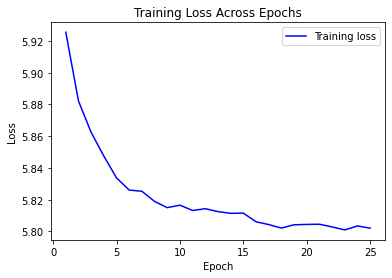

In [239]:
import matplotlib.pyplot as plt


loss = model.history.history['loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b-', label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Across Epochs')
plt.legend()
plt.show()

Lets test our model out! With only too epochs and too small context window we expect it to perform poorly.

We have to convert our input into model readable input, so lets recycle our vectorize_layer().

Test example from our training set. '6826 485 4589 7211 49122'

In [240]:
start_prompt = "6826 485 4589"

tokenized_example = vectorize_layer(start_prompt)

tokenized_example

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 17, 233, 111,   0], dtype=int64)>

Since we are not running batches and only a single observation, lets make some adjustments.

In [241]:
tokens = tokenized_example[:MAX_LEN]

x = np.expand_dims(tokens, axis=0)

y_pred, attention_scores = model.predict(x, verbose=0)

In [ ]:
# Get the probabilities for the next token
next_token_probs = y_pred[0][len(start_prompt.split())-1]  # position after your input

# Show top 5 predictions
k = 5
top_k_indices = np.argsort(next_token_probs)[-k:][::-1]
for idx in top_k_indices:
    print(f"Diagnosis Code: {vocab[idx]}, Probability: {next_token_probs[idx]:.4f}")

Token: 486, Probability: 4.0302
Token: v5789, Probability: 3.8886
Token: 4280, Probability: 3.8728
Token: 0389, Probability: 3.7248
Token: 49121, Probability: 3.6444
